In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
DCCC=pd.read_csv('google_review_ratings.csv')

In [3]:
DCCC=DCCC.dropna(how='any',axis=0)
x=DCCC.drop(['User'],axis=1)

In [4]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [5]:
print(DCCC.isnull().values.any())

False


In [6]:
Sil_Kmeans=[]
Sil_AVGkmeans=[]
K_Cluster=range(2,21)

In [22]:
def calculate_average_silhouette_score(X, z, n_init=10, n_runs=5):
    scores = []
    for i in range(n_runs):
        random_state = 42 * z + i
        kmeans = KMeans(n_clusters=z, init='random', n_init=n_init)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_, metric='euclidean')
        scores.append(score)
    return np.mean(scores)

silhouette_averages = []
for k in K_Cluster:
    average_score = calculate_average_silhouette_score(x, k)
    silhouette_averages.append(average_score)

maximum_score = max(silhouette_averages)
optimal_k = K_Cluster[silhouette_averages.index(maximum_score)]

In [26]:
print("The maximum average of silhouette score:", maximum_score)

The maximum average of silhouette score: 0.16173738989361122


In [27]:
print('Best K for KMeans with the silhouette score', maximum_score, 'is:', optimal_k)

Best K for KMeans with the silhouette score 0.16173738989361122 is: 20


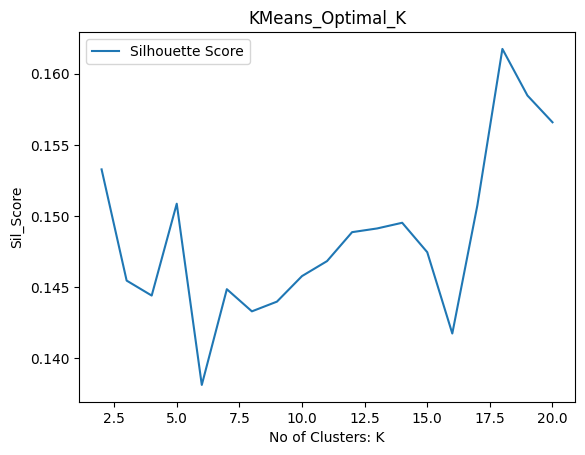

In [31]:
f,ax=plt.subplots(1,1)
plt.plot(K_Cluster, Sil_AVGkmeans, label='Silhouette Score')
plt.title('KMeans_Optimal_K')
plt.xlabel("No of Clusters: K")
plt.ylabel("Sil_Score")
plt.legend(loc='upper left')
plt.savefig('KMeans_Optimal_K.png')

In [32]:
def perform_kmeans(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=300, random_state=42, init='random')
    kmeans.fit(X)
    return kmeans

kmeans_model = perform_kmeans(x, optimal_k)

cluster_labels = kmeans_model.labels_
cluster_centroids = kmeans_model.cluster_centers_

DCCC['ClusterID'] = cluster_labels

centroids_kmeans = np.array(cluster_centroids)

In [33]:
print('Centroids Of KMeans: ', centroids_kmeans)

Centroids Of KMeans:  [[-2.84991979e-01  4.09091099e-01  3.45629320e-01  1.03131281e+00
   2.88202696e-01 -2.25963339e-01 -6.76582870e-01 -8.08253929e-01
   5.95898611e-01 -1.04029287e-02 -1.13936106e+00 -9.06965862e-01
  -8.20087836e-01 -6.85517652e-01 -4.12066760e-01  3.23432863e-01
  -3.33065821e-01 -2.12560960e-01 -2.13022636e-01  2.44707243e+00
   1.53604787e+00  1.19250931e+00  1.47886063e-01 -3.15832935e-01]
 [-8.80329798e-01  4.74290196e-01  4.29195741e-03 -1.04433338e+00
  -1.14509389e+00 -1.02529341e+00  9.77681750e-01  5.41301215e-01
   1.35568196e+00  1.45597464e+00  4.73267480e-01 -4.72394322e-02
  -3.62320084e-01  4.40445793e-02  8.38633664e-01 -4.20756286e-01
  -2.45565496e-01 -1.12515089e-01 -1.25181285e-01 -1.44739911e-01
  -2.09966548e-01 -6.71754986e-01 -6.85193211e-01 -7.75308232e-01]
 [-2.20764608e-01 -6.14354157e-01 -7.16908224e-01 -4.91253163e-01
  -5.17449321e-01 -3.67547802e-01  2.06654527e-02  9.63510344e-01
   9.57256514e-01  1.21484705e+00  1.76926309e+00  9

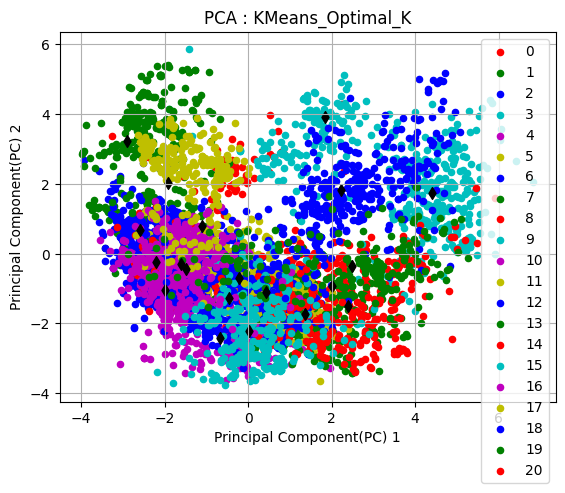

<Figure size 640x480 with 0 Axes>

In [34]:
x2=StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
projected = pca.fit_transform(x)
pca_centroid_kmeans=pca.fit_transform(centroids_kmeans)

pca_data=pd.DataFrame(data=projected, columns = ['PC1', 'PC2'])
pca_dataframe=pd.concat([pca_data,DCCC['ClusterID']], axis = 1)
f,ax = plt.subplots(1,1)
ax.set_title('PCA : KMeans_Optimal_K')
ax.set_xlabel('Principal Component(PC) 1')
ax.set_ylabel('Principal Component(PC) 2')
clusters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'b', 'g' ,'r', 'c', 'm', 'y', 'b' ,'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r' ,'c' ,'m' ,'y']
for cluster, color in zip(clusters, colors):
    indicesToKeep = pca_dataframe['ClusterID'] == cluster
    ax.scatter(pca_dataframe.loc[indicesToKeep, 'PC1']
               , pca_dataframe.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 20
              )
ax.scatter(pca_centroid_kmeans[:,0], pca_centroid_kmeans[:,1], marker="d", color='black')
ax.legend(clusters)
ax.grid()
plt.show()

plt.savefig('PCA_Kmeans.png')

In [46]:
# The visualization shows that the clusters are not well seperated

In [37]:
from sklearn.cluster import SpectralClustering
Sil_AVGgmm = []
Sil_AVGspectral = []

# Apply Gaussian Mixture Model
for z in K_Cluster:
    Sil_GMM = []
    for i in range(5):
        random_state = 42 * z + i
        gmm = GMM(n_components=z, random_state=random_state)
        gmm_labels = gmm.fit_predict(x)
        sil_score_gmm = silhouette_score(x, gmm_labels, metric='euclidean')
        Sil_GMM.append(sil_score_gmm)
    Sil_AVGgmm.append(np.mean(Sil_GMM))

# Apply Spectral Clustering
for z in K_Cluster:
    Sil_Spectral = []
    for i in range(5):
        random_state = 42 * z + i
        spectral = SpectralClustering(n_clusters=z, random_state=random_state, affinity='nearest_neighbors')
        spectral_labels = spectral.fit_predict(x)
        sil_score_spectral = silhouette_score(x, spectral_labels, metric='euclidean')
        Sil_Spectral.append(sil_score_spectral)
    Sil_AVGspectral.append(np.mean(Sil_Spectral))




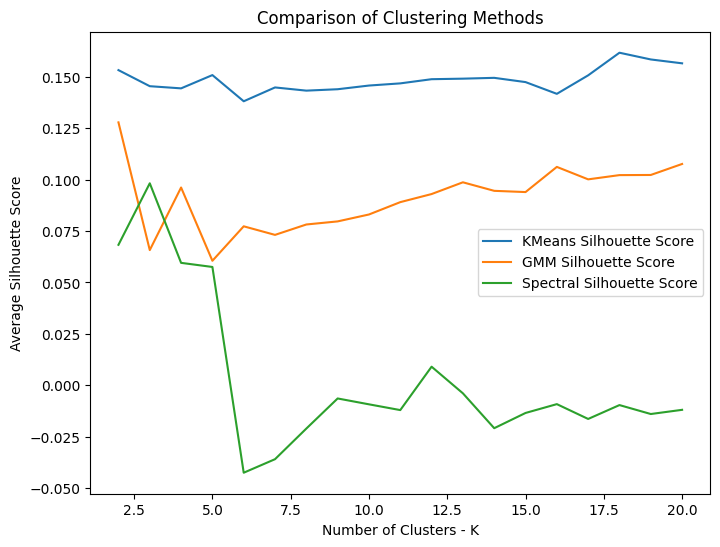

<Figure size 640x480 with 0 Axes>

In [45]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(K_Cluster, Sil_AVGkmeans, label='KMeans Silhouette Score')
plt.plot(K_Cluster, Sil_AVGgmm, label='GMM Silhouette Score')
plt.plot(K_Cluster, Sil_AVGspectral, label='Spectral Silhouette Score')

plt.title('Comparison of Clustering Methods')
plt.xlabel("Number of Clusters - K")
plt.ylabel("Average Silhouette Score")
plt.legend(loc='best')
plt.savefig('Comparison_of_Clustering_Methods.png')
plt.show()
plt.savefig('CCM.png')

In [39]:
kmeans_max = max(Sil_AVGkmeans)
gmm_max = max(Sil_AVGgmm)
spectral_max = max(Sil_AVGspectral)

In [40]:
print(f"Best average silhouette score for KMeans: {kmeans_max}")
print(f"Best average silhouette score for GMM: {gmm_max}")
print(f"Best average silhouette score for Spectral Clustering: {spectral_max}")

Best average silhouette score for KMeans: 0.16174030292706576
Best average silhouette score for GMM: 0.12785209518754043
Best average silhouette score for Spectral Clustering: 0.09821749957741925


In [41]:
best_method = 'KMeans'
best_score = kmeans_max

if gmm_max > best_score:
    best_method = 'GMM'
    best_score = gmm_max

if spectral_max > best_score:
    best_method = 'Spectral Clustering'
    best_score = spectral_max

print(f"The best method in terms of the average Silhouette coefficient is: {best_method} with a score of {best_score}")

The best method in terms of the average Silhouette coefficient is: KMeans with a score of 0.16174030292706576


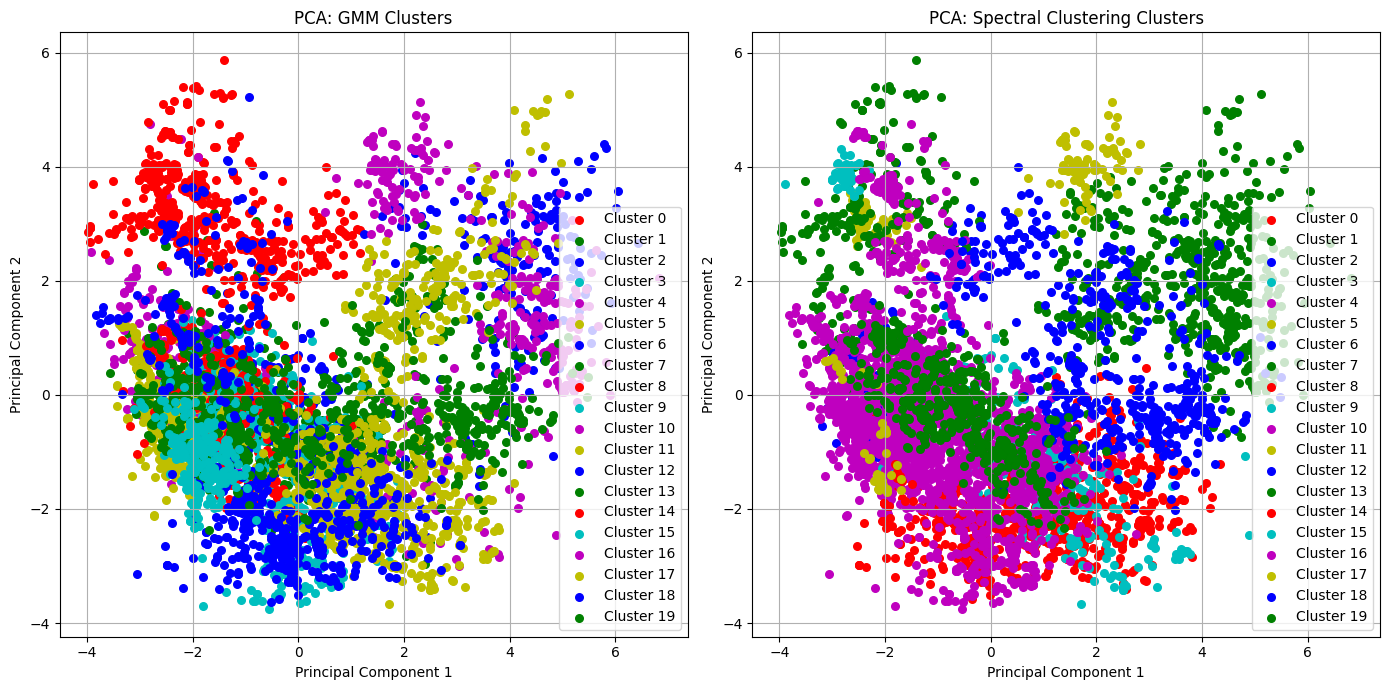

<Figure size 640x480 with 0 Axes>

In [42]:
pca = PCA(n_components=2)
pca_x = pca.fit_transform(x)

pca_data_gmm = pd.DataFrame(data=pca_x, columns=['PC1', 'PC2'])
pca_data_gmm['GMM_ClusterID'] = gmm_labels

pca_data_spectral = pd.DataFrame(data=pca_x, columns=['PC1', 'PC2'])
pca_data_spectral['Spectral_ClusterID'] = spectral_labels

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r' ,'c' ,'m' ,'y']

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title('PCA: GMM Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for cluster in range(optimal_k):
    cluster_data = pca_data_gmm[pca_data_gmm['GMM_ClusterID'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], s=30, c=colors[cluster], label=f'Cluster {cluster}')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('PCA: Spectral Clustering Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for cluster in range(optimal_k):
    cluster_data = pca_data_spectral[pca_data_spectral['Spectral_ClusterID'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], s=30, c=colors[cluster], label=f'Cluster {cluster}')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.savefig('PCA_GMM_Spectral.png')


In [48]:
# The visualization shows that the clusters are not well seperated
# The K-Means method is better since its silhouette-score is higher than the Gaussian mixture score.

In [44]:
eps_values = [0.5, 1, 1.5, 2]
min_samples_values = [5, 10, 15, 20]

dbscan_silhouette_scores = {}

for eps_value in eps_values:
    for min_samples_value in min_samples_values:

        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        dbscan_labels = dbscan.fit_predict(x)


        n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise_ = list(dbscan_labels).count(-1)

        print(f'EPS: {eps_value}, Min_Samples: {min_samples_value}')
        print('Estimated number of clusters:', n_clusters_)
        print('Estimated number of noise points:', n_noise_)


        if n_clusters_ > 1:
            silhouette_score_dbscan = silhouette_score(x, dbscan_labels)
            print('Silhouette Coefficient for DBSCAN:', silhouette_score_dbscan)
            dbscan_silhouette_scores[(eps_value, min_samples_value)] = silhouette_score_dbscan
        else:
            print("Silhouette Coefficient cannot be computed for one or no cluster.")
        print()


best_params = max(dbscan_silhouette_scores, key=dbscan_silhouette_scores.get)
best_score = dbscan_silhouette_scores[best_params]

print(f'Best DBSCAN parameters: EPS: {best_params[0]}, Min_Samples: {best_params[1]}')
print(f'Best Silhouette Coefficient for DBSCAN: {best_score}')


EPS: 0.5, Min_Samples: 5
Estimated number of clusters: 104
Estimated number of noise points: 4602
Silhouette Coefficient for DBSCAN: -0.32950965924828735

EPS: 0.5, Min_Samples: 10
Estimated number of clusters: 17
Estimated number of noise points: 5181
Silhouette Coefficient for DBSCAN: -0.33121029036316046

EPS: 0.5, Min_Samples: 15
Estimated number of clusters: 5
Estimated number of noise points: 5331
Silhouette Coefficient for DBSCAN: -0.1866838294041153

EPS: 0.5, Min_Samples: 20
Estimated number of clusters: 3
Estimated number of noise points: 5369
Silhouette Coefficient for DBSCAN: -0.15511104730564645

EPS: 1, Min_Samples: 5
Estimated number of clusters: 203
Estimated number of noise points: 3228
Silhouette Coefficient for DBSCAN: -0.10114280946976624

EPS: 1, Min_Samples: 10
Estimated number of clusters: 70
Estimated number of noise points: 4187
Silhouette Coefficient for DBSCAN: -0.23864128356555692

EPS: 1, Min_Samples: 15
Estimated number of clusters: 21
Estimated number of 